# 3. Hands on Reinforcement Learning

## 3.1 Monte Carlo estimations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('text', usetex = True) # to use LaTeX

import gym
import numpy as np
from collections import defaultdict
from utils import plot_state_values
from utils import plot_policy

In [3]:
env = gym.make('Blackjack-v0')
# env.seed(0)

### Monte-Carlo for estimating $V^{\pi}$

In [5]:
# define a policy that will HIT (action = 1) if the player's
# current value is <= 18
# and STICK (action = 0) otherwise
def generate_episode_deterministic(env):
    state = env.reset()
    episode = []
    while True:
        action = int(state[0] <= 18) # our policy
        next_state, reward, terminate, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminate:
            break
            
    return episode

In [6]:
def MCV(env, generate_episode, gamma, episodes):
    
    # initialize arbitrary V and returns
    V, returns = {}, {}
    
    # sample several episodes (= trajectories)
    for episode in range(episodes):
        trajectory = generate_episode(env)
        G, T = 0, len(trajectory)
        visited_state = set()
        
        # start with the smallest subtrajectory.
        # Add the reward to the 'returns' dictionary
        # only if the starting state of the subjectory
        # hadn't been encounter in a smaller subtrajectory
        for i in range(T-1, -1, -1):
            state, action, reward = trajectory[i]
            
            # sum of reward with discount factor gamma
            G += gamma**i * reward
            
            if state not in visited_state:
                reward, visits = returns.get(state, [0, 0])
                returns[state] = [reward + G, visits + 1]             
                visited_state.add(state)
    
    # get the average reward for each state. It is computed
    # as the sum of reward starting in state s divided
    # by the number of trajectories and subtrajectories
    # starting in state s
    for state, (sum_reward, n_visits) in returns.items():
        V[state] = sum_reward / n_visits
    
    return V

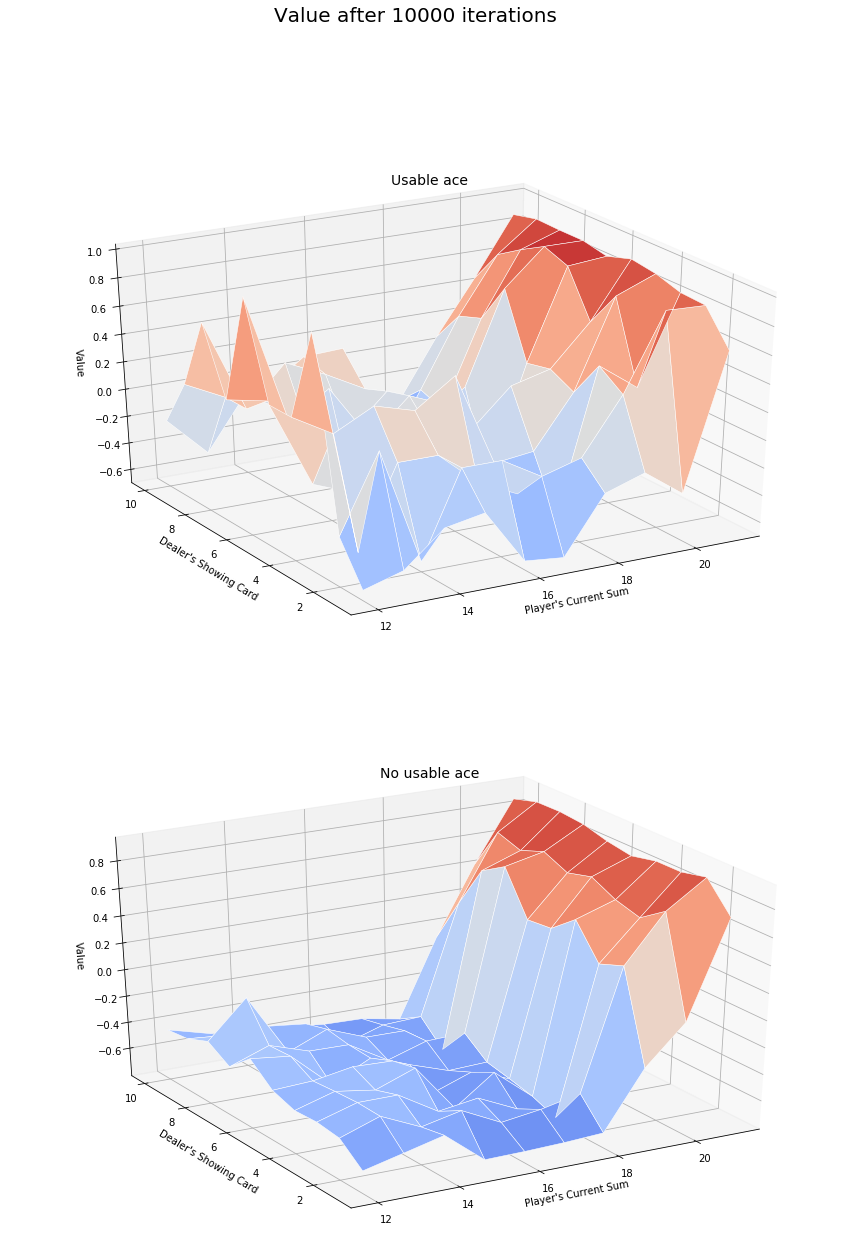

In [9]:
n_episodes = 10000
V = MCV(env, generate_episode_deterministic, 1.0, n_episodes)
plot_state_values(V, n_episodes)

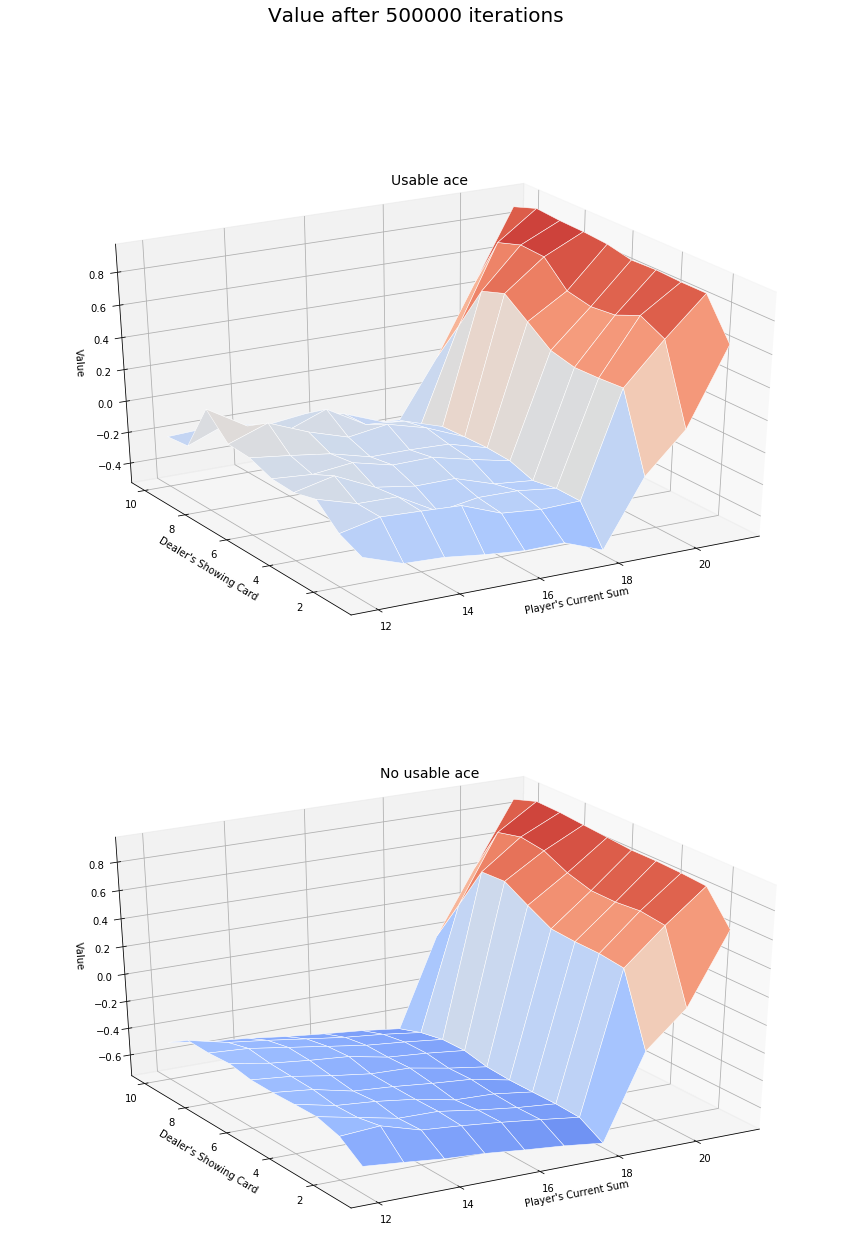

In [10]:
n_episodes = 500000
V = MCV(env, generate_episode_deterministic, 1.0, n_episodes)
plot_state_values(V, n_episodes)

### Monte-Carlo for estimating $Q^{\pi}$

example of policy:  
+ if current's player value > $18$ with probability $0.8$ **STICK** otherwise **HIT** (draw another card)
+ if current's player value < $18$ with probability $0.2$ **STICK** otherwise **HIT** (draw another card)

In [19]:
def generate_episode_stochastic(env):
    state = env.reset()
    episode = []
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice([0, 1], p=probs)
        next_state, reward, terminate, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminate:
            break
        
    return episode

utility function to transform $Q$ values into $V$ values.  
+ If player's current value > $18$ than with probability $0.8$ we **STICK** otherwise we **HIT**
+ If player's current value < $18$ than with probability $0.8$ we **HIT** otherwise we **STICK**  
the code to convert $Q$ to $V$ is then:

In [20]:
def QtoV(Q):
    """
    args:
        Q (dict): Q[(player's curren sum, dealers card, usableAc)] = [reward_if_stick, reward_if_hit]
    returns:
        V (dict): V[(player's curren sum, dealers card, usableAc)] = reward
    """
    V = {}
    for state, values in Q.items():
        if state[0] < 18:
            V[state] = np.array(values).dot([0.2, 0.8])
        else:
            V[state] = np.array(values).dot([0.8, 0.2])
    
    return V

In [21]:
def MCQ(env, generate_episode, gamma, episodes):
    n_actions = env.action_space.n
    
    # initialize arbitrarily pi, Q, returns
    pi = {}
    Q = defaultdict(lambda: np.zeros(n_actions))
    returns = {}
    
    for episode in range(episodes):
        trajectory = generate_episode(env)
        G, T = 0, len(trajectory)
        
        for i in range(T-1, -1, -1):
            state, action, reward = trajectory[i]
            G += gamma**i * reward
            
            visited_state = set()
            if (state, action) not in visited_state:
                # append G to returns (s_t, a_t)
                reward, visits = returns.get((state, action), [0, 0])
                returns[(state, action)] = [reward + G, visits + 1] 
                visited_state.add((state, action))
    
    # take the average
    for (state, action), (sum_reward, n_visits) in returns.items():
        Q[state][action] = sum_reward / n_visits
    
    for state, rewards in Q.items():
        pi[state] = np.argmax(rewards)
    
    return Q, pi

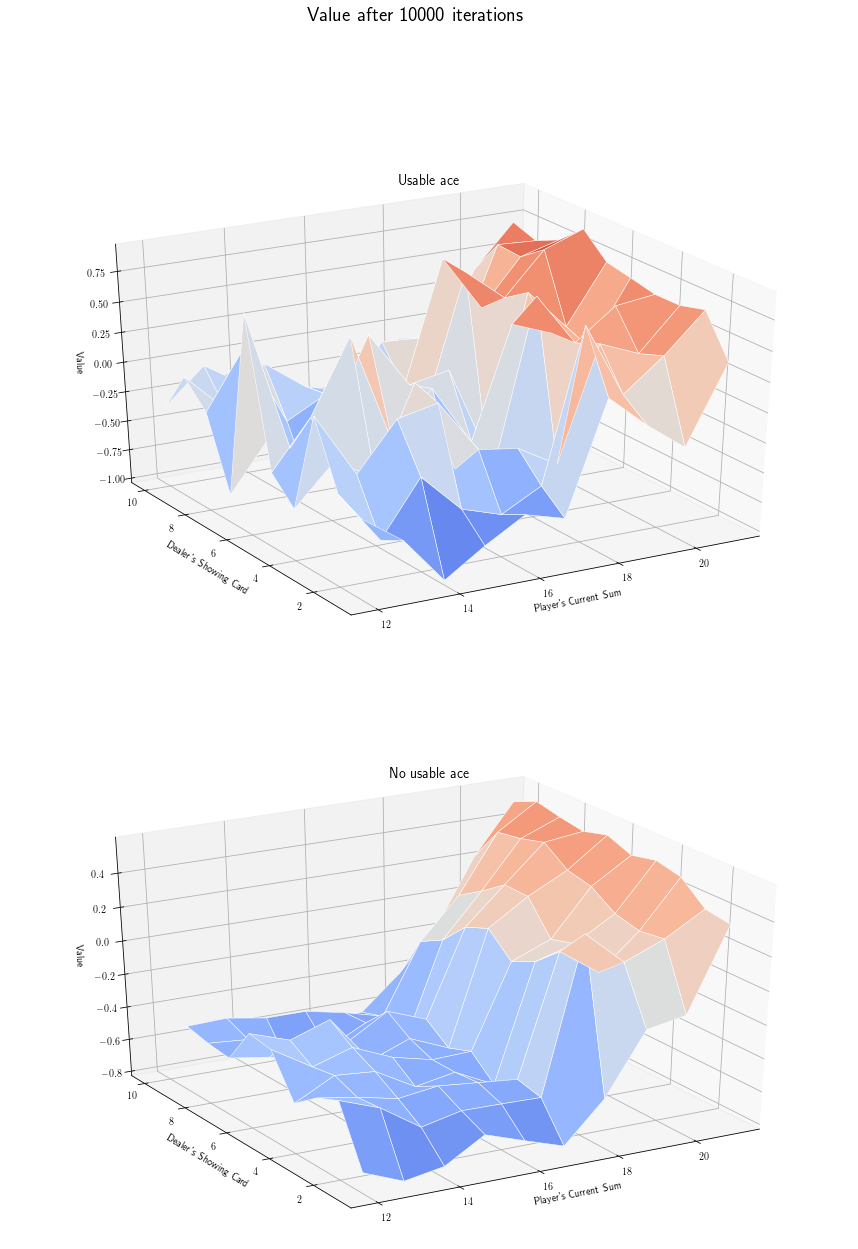

In [22]:
n_episodes = 10000
Q, pi = MCQ(env, generate_episode_stochastic, 1.0, n_episodes)
V = QtoV(Q)
plot_state_values(V, n_episodes)

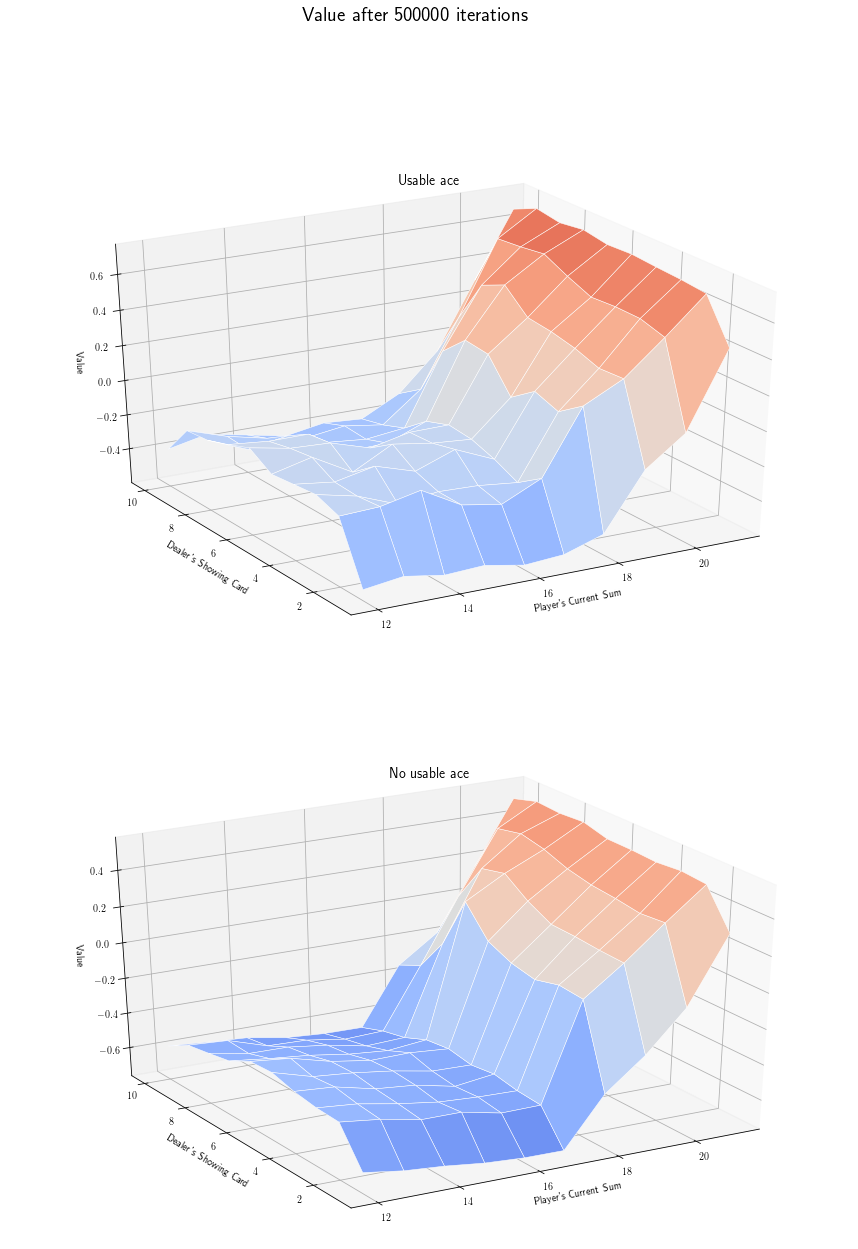

In [23]:
n_episodes = 500000
Q, pi = MCQ(env, generate_episode_stochastic, 1.0, n_episodes)
V = QtoV(Q)
plot_state_values(V, n_episodes)

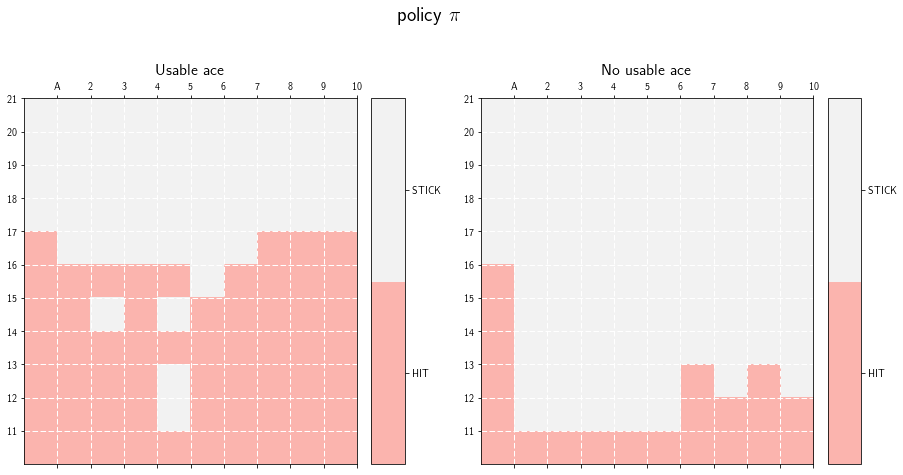

In [26]:
plot_policy(pi, r"policy $\pi$")